In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)
matplotlib 3.6.3
numpy 1.24.3
pandas 1.5.2
sklearn 1.2.0
torch 1.13.1+cu117
cuda:0


## 数据准备

https://www.kaggle.com/competitions/cifar-10/data

```shell
$ tree -L 1 cifar-10                                    
cifar-10
├── sampleSubmission.csv
├── test
├── train
└── trainLabels.csv
```

In [2]:
from pathlib import Path

DATA_DIR = Path("./cifar-10")

train_lables_file = DATA_DIR / "trainLabels.csv"
test_csv_file = DATA_DIR / "sampleSubmission.csv"
train_folder = DATA_DIR / "train/"
test_folder = DATA_DIR / "test"

#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
#         lines = f.readlines()  为什么加[1:]，可以试这个
        #第一行不需要，因为第一行是标签
        lines = f.readlines()[1:] 
    for line in lines:#依次去取每一行
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = folder / f"{image_id}.png"
        results.append((image_full_path, label_str)) #得到对应图片的路径和分类
    return results

#解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[(PosixPath('cifar-10/train/1.png'), 'frog'),
 (PosixPath('cifar-10/train/2.png'), 'truck'),
 (PosixPath('cifar-10/train/3.png'), 'truck'),
 (PosixPath('cifar-10/train/4.png'), 'deer'),
 (PosixPath('cifar-10/train/5.png'), 'automobile')]
[(PosixPath('cifar-10/test/1.png'), 'cat'),
 (PosixPath('cifar-10/test/2.png'), 'cat'),
 (PosixPath('cifar-10/test/3.png'), 'cat'),
 (PosixPath('cifar-10/test/4.png'), 'cat'),
 (PosixPath('cifar-10/test/5.png'), 'cat')]
50000 300000


In [3]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

               filepath       class
0  cifar-10/train/1.png        frog
1  cifar-10/train/2.png       truck
2  cifar-10/train/3.png       truck
3  cifar-10/train/4.png        deer
4  cifar-10/train/5.png  automobile
                   filepath       class
0  cifar-10/train/45001.png       horse
1  cifar-10/train/45002.png  automobile
2  cifar-10/train/45003.png        deer
3  cifar-10/train/45004.png  automobile
4  cifar-10/train/45005.png    airplane
              filepath class
0  cifar-10/test/1.png   cat
1  cifar-10/test/2.png   cat
2  cifar-10/test/3.png   cat
3  cifar-10/test/4.png   cat
4  cifar-10/test/5.png   cat


In [4]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Cifar10Dataset(Dataset):
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }
    label_to_idx = {label: idx for idx, label in enumerate(class_names)}
    idx_to_label = {idx: label for idx, label in enumerate(class_names)}
    def __init__(self, mode, transform=None):
        self.df = self.df_map.get(mode, None)
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))

        self.transform = transform
        
    def __getitem__(self, index):
        img_path, label = self.df.iloc[index]
        img = Image.open(img_path).convert('RGB')
        # # img 转换为 channel first
        # img = img.transpose((2, 0, 1))
        # transform
        img = self.transform(img)
        # label 转换为 idx
        label = self.label_to_idx[label]
        return img, label
    
    def __len__(self):
        return self.df.shape[0]
    
IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transforms_train = transforms.Compose([
        # resize
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        # random rotation 40
        transforms.RandomRotation(40),
        # horizaontal flip
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

transforms_eval = transforms.Compose([
        # resize
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

train_ds = Cifar10Dataset("train", transforms_train)
eval_ds = Cifar10Dataset("eval", transforms_eval) 

In [5]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)   
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
# def cal_mean_std(ds):
#     mean = 0.
#     std = 0.
#     for img, _ in ds:
#         mean += img.mean(dim=(1, 2))
#         std += img.std(dim=(1, 2))
#     mean /= len(ds)
#     std /= len(ds)
#     return mean, std
#
# # 经过 normalize 后 均值为0，方差为1
# print(cal_mean_std(train_ds))

(tensor([-0.2207, -0.2280, -0.1984]), tensor([0.9980, 0.9955, 0.9041]))


## 定义模型

In [7]:
class VGG(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(512, num_classes),
        )
        self.init_weights()
        
    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        return self.model(x)
        
for key, value in VGG(len(class_names)).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")
    


             model.0.weight             paramerters num: 864
              model.0.bias              paramerters num: 32
             model.2.weight             paramerters num: 9216
              model.2.bias              paramerters num: 32
             model.5.weight             paramerters num: 9216
              model.5.bias              paramerters num: 32
             model.7.weight             paramerters num: 9216
              model.7.bias              paramerters num: 32
            model.10.weight             paramerters num: 9216
             model.10.bias              paramerters num: 32
            model.12.weight             paramerters num: 9216
             model.12.bias              paramerters num: 32
            model.16.weight             paramerters num: 5120
             model.16.bias              paramerters num: 10


## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [8]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [9]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [10]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [11]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [12]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 10

model = VGG(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/vgg")
tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/vgg", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)
record = training(
    model, 
    train_dl, 
    eval_dl, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
    )

2023-06-01 00:14:13.700508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  0%|          | 0/7040 [00:00<?, ?it/s]

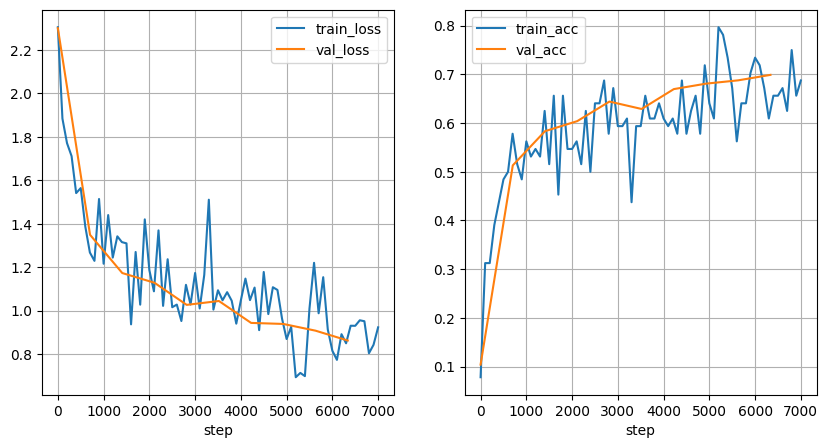

In [13]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=100)  #横坐标是 steps

# 评估

In [14]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/vgg/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.8624
accuracy: 0.6990


# 推理

In [15]:
# test_df
test_ds = Cifar10Dataset("test", transform=transforms_eval)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

preds_collect = []
model.eval()
for data, fake_label in tqdm(test_dl):
    data = data.to(device=device)
    logits = model(data)
    preds = [test_ds.idx_to_label[idx] for idx in logits.argmax(axis=-1).cpu().tolist()]
    preds_collect.extend(preds)
    
test_df["class"] = preds_collect
test_df.head()

  0%|          | 0/4688 [00:00<?, ?it/s]

,filepath,class
0,cifar-10/test/1.png,deer
1,cifar-10/test/2.png,airplane
2,cifar-10/test/3.png,truck
3,cifar-10/test/4.png,ship
4,cifar-10/test/5.png,bird


In [16]:
# 导出 submission.csv
test_df.to_csv("submission.csv", index=False)